# Zadanie 1: Sprawdzanie Obliczeń Arytmetycznych w Scenariuszu Few-Shot

W tym zadaniu chcemy zbadać, jak dobrze wybrany model językowy (100M-1B parametrów)
radzi sobie z obliczeniami prostych wyrażeń arytmetycznych w scenariuszu few-shot.

**Wymagania:**
1. Pokazać scenariusz, w którym wyniki modelu są istotnie lepsze niż losowe.
2. Wyciągnąć wnioski i zawrzeć je w notatniku.

**Opcje dodatkowe:** 
- Analiza błędów i ewentualnych zniekształceń (bias).
- Bardziej złożone działania arytmetyczne.
- Badanie wrażliwości na zmiany w prompty.

W niniejszym notatniku zademonstruję prosty scenariusz, gdzie model ma za zadanie
wykonać dodawanie i odejmowanie liczb całkowitych z pewnym kontekstem w stylu few-shot.
"""


In [1]:
# 2) Importy i Inicjalizacja

import os
import sys

# Zakładamy, że nasz "utils.py" jest w katalogu nadrzędnym:
sys.path.append('..')

from utils import load_qa_pairs, evaluate_model, LanguageModel

# Inicjalizacja modelu
handler = LanguageModel()  # Zależnie od implementacji wewnątrz utils

/pio/scratch/1/i317214/miniconda/envs/hallucination_detection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Loading model: eryk-mazus/polka-1.1b
[INFO] Using device: cuda


Aby zademonstrować zdolności modelu, wygenerujemy zestaw prostych przykładów 
dodawania i odejmowania. Będziemy zadawać pytania typu 'Ile to jest X + Y?' lub 
'Ile to jest X - Y?'.

Następnie model otrzyma pewien prompt few-shot, w którym pokażemy mu, jak 
poprawnie odpowiadać. Następnie sprawdzimy, jaki procent poprawnych wyników 
uzyskamy. Na końcu porównamy wynik z losowym strzelaniem.

In [2]:
# 4) Generowanie Prostej Bazy Zadaniowej
import random

def generate_arithmetic_questions(n=20, max_val=20):
    """
    Generuje proste pytania w formacie:
    "Ile to jest X + Y?" lub "Ile to jest X - Y?"
    Zwraca listę (pytanie, odpowiedź).
    """
    data = []
    for _ in range(n):
        x = random.randint(0, max_val)
        y = random.randint(0, max_val)
        
        if random.random() < 0.5:
            # Dodawanie
            question = f"Ile to jest {x} + {y}?"
            answer = str(x + y)
        else:
            # Odejmowanie
            question = f"Ile to jest {x} - {y}?"
            answer = str(x - y)
        
        data.append((question, answer))
    return data

# Generujemy np. 20 przykładów do testu
test_data = generate_arithmetic_questions(n=20, max_val=30)

# Sprawdzamy przykładowe pary
for q, a in test_data[:5]:
    print(f"Pytanie: {q} | Odpowiedź: {a}")

Pytanie: Ile to jest 22 + 21? | Odpowiedź: 43
Pytanie: Ile to jest 17 - 29? | Odpowiedź: -12
Pytanie: Ile to jest 29 - 22? | Odpowiedź: 7
Pytanie: Ile to jest 5 + 2? | Odpowiedź: 7
Pytanie: Ile to jest 4 - 10? | Odpowiedź: -6


Napiszemy funkcję, która stworzy prompt w stylu few-shot:
- Dodamy kilka przykładów z poprawnym rozwiązaniem,
- Potem wstawimy aktualne pytanie i poprosimy o wynik.

Następnie poprosimy model o wygenerowanie odpowiedzi.

In [3]:
few_shot_examples = [
    ("Ile to jest 2 + 3?", "5"),
    ("Ile to jest 10 - 4?", "6"),
    ("Ile to jest 7 + 7?", "14"),
]

def build_few_shot_prompt(question: str) -> str:
    """
    Buduje prompt few-shot, pokazując kilka przykładowych pytań i odpowiedzi,
    po czym pyta o docelowe pytanie.
    """
    prompt = "Odpowiadaj tylko liczbą (bez tekstu dodatkowego). Oto przykłady:\n\n"
    for ex_q, ex_a in few_shot_examples:
        prompt += f"Pytanie: {ex_q}\nOdpowiedź: {ex_a}\n\n"
    prompt += f"Pytanie: {question}\nOdpowiedź:"
    return prompt

In [11]:
# 7) Funkcja Generująca Odpowiedzi z Modelu w Stylu Few-Shot

def generate_arithmetic_answer(question: str, handler: LanguageModel) -> str:
    """
    Konstruuje prompt few-shot i wywołuje model, aby wygenerować odpowiedź.
    Następnie zwraca ją w formie stringu (np. '5').
    """
    prompt = build_few_shot_prompt(question)
    
    # Zakładamy, że LanguageModel ma metodę generate_text
    # Możemy podać parametry: max_new_tokens, temperature itp.
    generated = handler.generate_text(
        prompt=prompt,
        max_new_tokens=5,        # wystarczy mały limit
        temperature=0.0,         # deterministyczne generowanie
        top_k=50,
        top_p=0.95
    )
    
    return generated.split("\n")[0].strip()

In [12]:
# 8) Testowanie i Ewaluacja
# Porównamy odpowiedzi modelu z ground truth i sprawdzimy trafność

correct = 0
total = len(test_data)

for (q, true_ans) in test_data:
    model_ans = generate_arithmetic_answer(q, handler)
    # Porównujemy z prawdziwą odpowiedzią
    if model_ans == true_ans:
        correct += 1
    else:
        print(f"[BŁĄD] {q} => Model: {model_ans}, Poprawna: {true_ans}")

accuracy = correct / total
print(f"\nUzyskana dokładność: {accuracy * 100:.2f}% ({correct}/{total})")

[BŁĄD] Ile to jest 17 - 29? => Model: 12, Poprawna: -12
[BŁĄD] Ile to jest 4 - 10? => Model: 4, Poprawna: -6
[BŁĄD] Ile to jest 16 + 24? => Model: 39, Poprawna: 40
[BŁĄD] Ile to jest 3 - 6? => Model: 7, Poprawna: -3
[BŁĄD] Ile to jest 28 + 1? => Model: 39, Poprawna: 29
[BŁĄD] Ile to jest 13 - 24? => Model: 10, Poprawna: -11
[BŁĄD] Ile to jest 18 - 19? => Model: 1, Poprawna: -1
[BŁĄD] Ile to jest 2 - 17? => Model: 10, Poprawna: -15
[BŁĄD] Ile to jest 8 + 11? => Model: 29, Poprawna: 19
[BŁĄD] Ile to jest 28 - 30? => Model: 10, Poprawna: -2
[BŁĄD] Ile to jest 1 + 9? => Model: 2, Poprawna: 10

Uzyskana dokładność: 45.00% (9/20)


Dla porównania policzymy średnie trafienie "losowe".
W naszym wypadku, jeśli generujemy losowo liczbę w jakimś zakresie, np. -30 do 60 
(dla max_val=30, odejmowanie może dać minus, dodawanie max 60), 
to prawdopodobieństwo trafienia w jedną konkretną liczbę jest ~1/(60+30+1) itp. 
lub sprawdzamy empirycznie.

In [14]:
# 10) Porównanie z Losowym (kod)
import random

def random_guess_arithmetic(test_data):
    """
    Zwraca, ile trafień mielibyśmy, gdybyśmy zgadywali w pewnym zakresie, np. od -30 do 60
    """
    guess_range = range(-30, 61)
    correct_rand = 0
    for (q, true_ans) in test_data:
        # losujemy str(liczba)
        guess = str(random.choice(guess_range))
        if guess == true_ans:
            correct_rand += 1
    return correct_rand

random_correct = random_guess_arithmetic(test_data)
random_accuracy = random_correct / len(test_data)
print(f"Losowe trafienie: {random_accuracy*100:.2f}% ({random_correct}/{len(test_data)})")


Losowe trafienie: 0.00% (0/20)


Generowanie macierzy (x + y):



Tworzenie heatmapy: 100%|██████████| 1600/1600 [02:20<00:00, 11.37it/s]


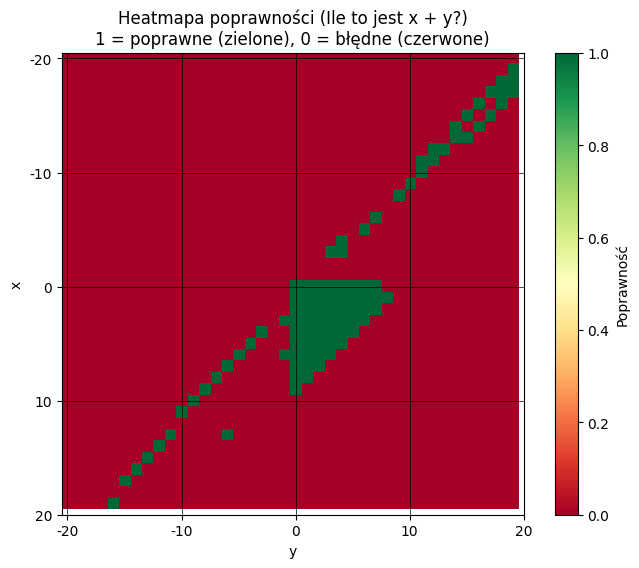

In [23]:
# 12) Heatmap: 100 x 100 (x + y) – zaznaczenie poprawnych i błędnych odpowiedzi
# Wszystko w jednej komórce, z użyciem tqdm i matplotlib

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

N = 100
results_matrix = np.zeros((N, N))

print("Generowanie macierzy (x + y):\n")
with tqdm(total=N*N, desc="Tworzenie heatmapy") as pbar:
    for x in range(N):
        x = int(x - N/2)
        for y in range(N):
            y = int(y - N/2)
            question = f"Ile to jest {x} + {y}?"
            correct_answer = str(x + y)

            # Generujemy odpowiedź modelu (few-shot):
            prompt = build_few_shot_prompt(question)
            generated = handler.generate_text(
                prompt=prompt,
                max_new_tokens=5,
                temperature=0.0,
                top_k=50,
                top_p=0.95
            )
            if not generated:
                model_ans = ""
            else:
                raw_answer = generated[0].replace(prompt, "").strip()
                raw_answer = raw_answer.replace("Odpowiedź:", "").strip().rstrip(".!? ")
                model_ans = raw_answer

            # Sprawdzamy poprawność:
            if model_ans == correct_answer:
                results_matrix[int(x+N/2), int(y+N/2)] = 1  # 1 = poprawne
            else:
                results_matrix[int(x+N/2), int(y+N/2)] = 0  # 0 = błędne
            
            pbar.update(1)

# Wizualizacja: 1 = zielone, 0 = czerwone
plt.figure(figsize=(8, 6))
plt.title("Heatmapa poprawności (Ile to jest x + y?)\n1 = poprawne (zielone), 0 = błędne (czerwone)")
plt.imshow(results_matrix, cmap="RdYlGn", origin='upper')
plt.colorbar(label="Poprawność")
plt.xlabel("y")
plt.ylabel("x")
# adjust axis
plt.xticks(np.linspace(0, N, 5), np.linspace(-N/2, N/2, 5).astype(int))
plt.yticks(np.linspace(0, N, 5), np.linspace(-N/2, N/2, 5).astype(int))
# display black grid
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('heatmap_addition.png')
plt.show()


Generowanie macierzy (x - y):



Tworzenie heatmapy: 100%|██████████| 1600/1600 [02:19<00:00, 11.46it/s]


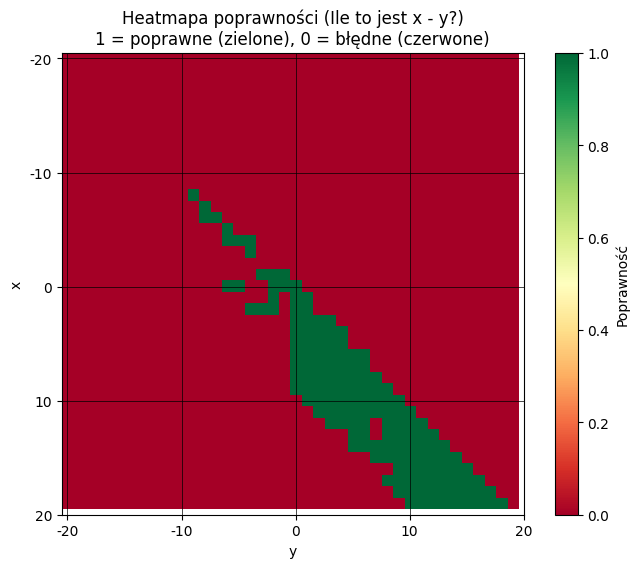

In [24]:
# 12) Heatmap: 100 x 100 (x + y) – zaznaczenie poprawnych i błędnych odpowiedzi
# Wszystko w jednej komórce, z użyciem tqdm i matplotlib

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

N = 100
results_matrix = np.zeros((N, N))

print("Generowanie macierzy (x - y):\n")
with tqdm(total=N*N, desc="Tworzenie heatmapy") as pbar:
    for x in range(N):
        x = int(x - N/2)
        for y in range(N):
            y = int(y - N/2)
            question = f"Ile to jest {x} - {y}?"
            correct_answer = str(x - y)

            # Generujemy odpowiedź modelu (few-shot):
            prompt = build_few_shot_prompt(question)
            generated = handler.generate_text(
                prompt=prompt,
                max_new_tokens=5,
                temperature=0.0,
                top_k=50,
                top_p=0.95
            )
            if not generated:
                model_ans = ""
            else:
                raw_answer = generated[0].replace(prompt, "").strip()
                raw_answer = raw_answer.replace("Odpowiedź:", "").strip().rstrip(".!? ")
                model_ans = raw_answer

            # Sprawdzamy poprawność:
            if model_ans == correct_answer:
                results_matrix[int(x+N/2), int(y+N/2)] = 1  # 1 = poprawne
            else:
                results_matrix[int(x+N/2), int(y+N/2)] = 0  # 0 = błędne
            
            pbar.update(1)

# Wizualizacja: 1 = zielone, 0 = czerwone
plt.figure(figsize=(8, 6))
plt.title("Heatmapa poprawności (Ile to jest x - y?)\n1 = poprawne (zielone), 0 = błędne (czerwone)")
plt.imshow(results_matrix, cmap="RdYlGn", origin='upper')
plt.colorbar(label="Poprawność")
plt.xlabel("y")
plt.ylabel("x")
# adjust axis
plt.xticks(np.linspace(0, N, 5), np.linspace(-N/2, N/2, 5).astype(int))
plt.yticks(np.linspace(0, N, 5), np.linspace(-N/2, N/2, 5).astype(int))
# display black grid
# plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('heatmap_substraction.png')
plt.show()
